# Flood - Visualize -  Presentation Figures
<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 06/23/2016 <br/>
</h3>

# Setup

In [58]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import flood_functions
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio 
import seaborn as sns
import statsmodels.api as sm

from IPython.display import display, HTML
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print 'Matplotlib Styles:', '\n'.join(plt.style.available)

Matplotlib Styles: seaborn-darkgrid
seaborn-notebook
classic
seaborn-ticks
grayscale
bmh
seaborn-talk
dark_background
ggplot
fivethirtyeight
seaborn-colorblind
seaborn-deep
seaborn-whitegrid
seaborn-bright
seaborn-poster
seaborn-muted
seaborn-paper
seaborn-white
seaborn-pastel
seaborn-dark
seaborn-dark-palette


In [15]:
#%matplotlib
%pylab inline

plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [4]:
dir_flood = '../../Raw Data/Flood Observatory/'
dir_python_data = '../Data/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/'

# Load Data

## Spatial Data

#### GRACE

In [5]:
# lowres grace features
f = open(dir_python_data + 'grace_features_lowres.p', 'rb')
feature_bricks = pickle.load(f)
f.close()

In [6]:
# lowres land mask
f = open(dir_python_data + 'grace_land_mask_lowres.p', 'rb')
land_mask = pickle.load(f)
f.close()

land_mask = np.flipud(land_mask.transpose())

### Flood Events

In [7]:
# lowres flood events
f = open(dir_python_data+'flood_event_brick_lowres.p', 'rb')
flood_brick = pickle.load(f)
f.close()

flood_brick = flood_brick[0]
flood_brick = np.flipud(flood_brick.transpose((1, 0, 2)))

### Modis Land Coverage

In [8]:
# lowres modis land coverage maps
f = open(dir_python_data + 'modis_mask_dict.p', 'rb')
modis_mask_dict = pickle.load(f)
f.close()

## Flood Observatory

In [9]:
df_name = 'df_flood_grace_time_location_features'

In [10]:
df_flood_grace = pd.read_csv(dir_python_data + df_name + '.csv')
df_flood_grace = df_flood_grace.drop('Unnamed: 0', axis=1)

print df_flood_grace.shape
df_flood_grace.head(1)

(1977, 41)


,Register #,Began,Date Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,...,GRACE lwe clim rank,GRACE lwe clim rank norm,GRACE lwe noClim rank,GRACE lwe noClim rank norm,GRACE lwe rank post,GRACE lwe rank norm post,GRACE lwe clim rank post,GRACE lwe clim rank norm post,GRACE lwe noClim rank post,GRACE lwe noClim rank norm post
0,4352.0,13-Apr-16,13-Apr-16,22-Apr-16,10.0,0.0,0.0,Tropical Storm Fantala,1.0,117235.21,...,3.0,-0.995557,142.0,1.487868,0.0,0.0,0.0,0.0,0.0,0.0


# Analysis

In [11]:
# section variables
tp = flood_brick.shape[2]
df = df_flood_grace

fig_large = (18,9.9)
fig_small = (9,4.45)

In [37]:
# performs linear regression, outputs plot and statistics
def regression(df, x_col_name, y_col_name, plt_title):

    # define data
    x = df[x_col_name]
    y = df[y_col_name]

    # calculate x-raange
    x_max = x.max()
    x_min = x.min()

    # setup
    fig, ax = plt.subplots(figsize=fig_large)

    # scatter plot
    ax.scatter(x,y,alpha=0.25)

    # fitted line: y ~ c + x
    x = sm.add_constant(x) # add intercept term
    model = sm.OLS(y,x) # create model
    fitted = model.fit() # fit model
    x_pred = np.linspace(x_max,x_min,50) # create x values for fitted lin
    x_pred2 = sm.add_constant(x_pred) # add intercept term
    y_pred = fitted.predict(x_pred2) # predict y-values for fitted line
    ax.plot(x_pred, y_pred, '-', color='red', linewidth=2) # plot fitted line

    # print fitted line results
    print(fitted.params)
    print(fitted.summary())

    # confidence interval
    y_hat = fitted.predict(x)
    y_err = y - y_hat
    mean_x = x.T[1].mean()
    n = len(x)
    dof = n - fitted.df_model - 1
    t = stats.t.ppf(1-0.025, df=dof)
    s_err = np.sum(np.power(y_err, 2))
    conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2) / \
            ((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
    upper = y_pred + abs(conf)
    lower = y_pred - abs(conf)
    ax.fill_between(x_pred, lower, upper, color='#888888', alpha=0.4)

    # plot labels
    plt.xlabel(x_col_name)
    plt.ylabel(y_col_name)
    plt.title(plt_title)


    plt.show()

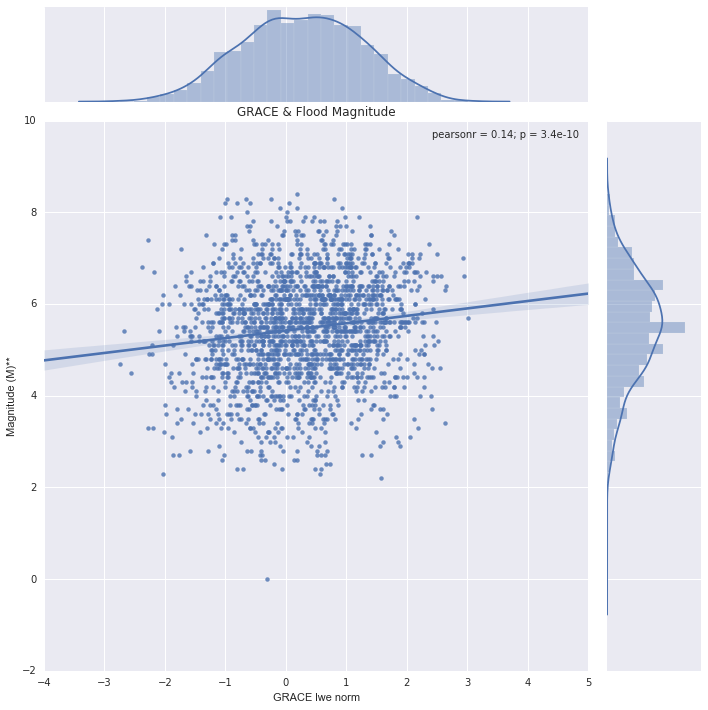

In [89]:
sns.jointplot(x='GRACE lwe norm',y='Magnitude (M)**', data=df, kind='reg',
             size=10)
plt.title('GRACE & Flood Magnitude')
plt.show()

const             5.417546
GRACE lwe norm    0.161867
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Magnitude (M)**   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     39.86
Date:                Tue, 02 Aug 2016   Prob (F-statistic):           3.36e-10
Time:                        09:08:22   Log-Likelihood:                -3031.5
No. Observations:                1977   AIC:                             6067.
Df Residuals:                    1975   BIC:                             6078.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------

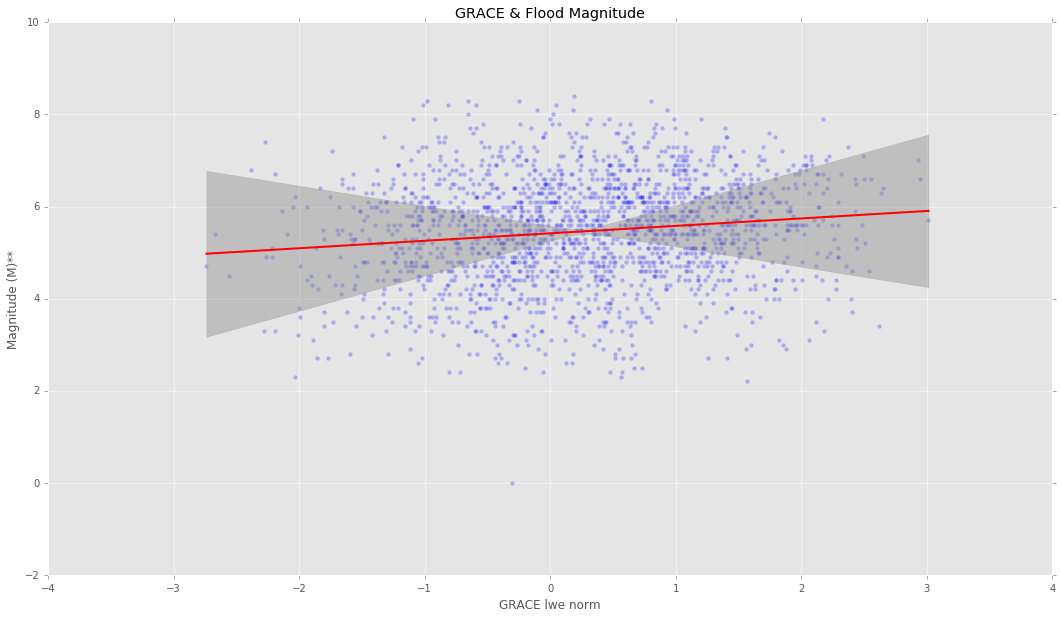

In [38]:
regression(df=df, 
           x_col_name='GRACE lwe norm', 
           y_col_name='Magnitude (M)**',
           plt_title= 'GRACE & Flood Magnitude')

const     5.460711
random    0.004518
dtype: float64
                            OLS Regression Results                            
Dep. Variable:        Magnitude (M)**   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03123
Date:                Tue, 02 Aug 2016   Prob (F-statistic):              0.860
Time:                        09:15:06   Log-Likelihood:                -3051.2
No. Observations:                1977   AIC:                             6106.
Df Residuals:                    1975   BIC:                             6118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------

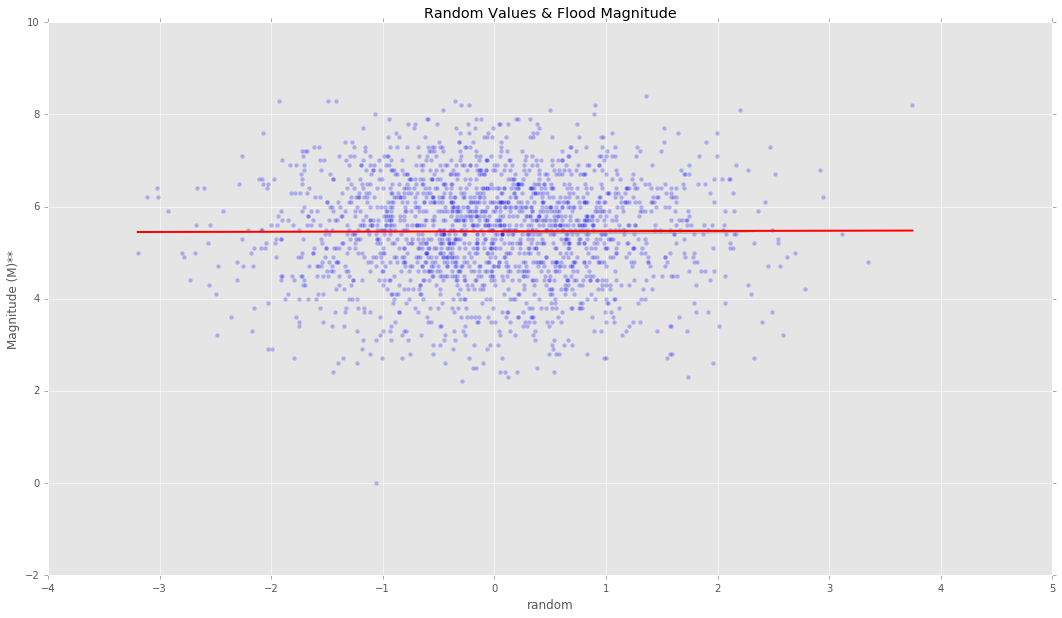

In [49]:
df['random'] = np.random.randn(df.shape[0])
regression(df=df, 
           x_col_name='random', 
           y_col_name='Magnitude (M)**',
           plt_title= 'Random Values & Flood Magnitude')